In [6]:
from PAGEpy import PAGEpy_utils
from PAGEpy import PAGEpy_plot
from PAGEpy import pso
from PAGEpy.format_data_class import FormatData
from PAGEpy.pred_ann_model import PredAnnModel
import pickle
import pandas as pd

#memory growth is enabled for for the gpu
PAGEpy_utils.init_cuda()

#establish the formatdata object using your bulk rna data set
current_data = FormatData(pval_cutoff = 0.00005, data_dir = '/your/dir/with_Bulk_data/', gene_selection = 'Diff', pval_correction = 'benjamini-hochberg')

# the feature set selected by FormatData is stored locally
genes_path = '/your/dir/feature_set.pkl'

with open(genes_path, 'rb') as f:
    current_genes = pickle.load(f)

# train the model
old_model = PredAnnModel(current_data,current_genes,num_epochs=500)

Memory growth enabled for PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Anndata successfully constructed.
Anndata object counts are now normalized.
The total length of the genes list or feature set is: 1757.
Epoch 0, Avg Outcome Loss: 0.6870, Train AUC: 0.5000, Train Accuracy: 0.7214, Test AUC: 0.5000, Test Accuracy: 0.7246
Epoch 10, Avg Outcome Loss: 69.2125, Train AUC: 0.4994, Train Accuracy: 0.2786, Test AUC: 0.5000, Test Accuracy: 0.2754
Epoch 20, Avg Outcome Loss: 2.8496, Train AUC: 0.3725, Train Accuracy: 0.7214, Test AUC: 0.4414, Test Accuracy: 0.7246
Epoch 30, Avg Outcome Loss: 15.0984, Train AUC: 0.4076, Train Accuracy: 0.7214, Test AUC: 0.4399, Test Accuracy: 0.7246
Epoch 40, Avg Outcome Loss: 0.7918, Train AUC: 0.6574, Train Accuracy: 0.2786, Test AUC: 0.5764, Test Accuracy: 0.2754
Epoch 50, Avg Outcome Loss: 3.4453, Train AUC: 0.6440, Train Accuracy: 0.6837, Test AUC: 0.6100, Test Accuracy: 0.7006
Epoch 60, Avg Outcome Loss: 0.7128, Train AUC: 0.6637, Tra

max train accuracy: 0.75
max train auc: 0.82
max test accuracy: 0.74
max test auc: 0.67


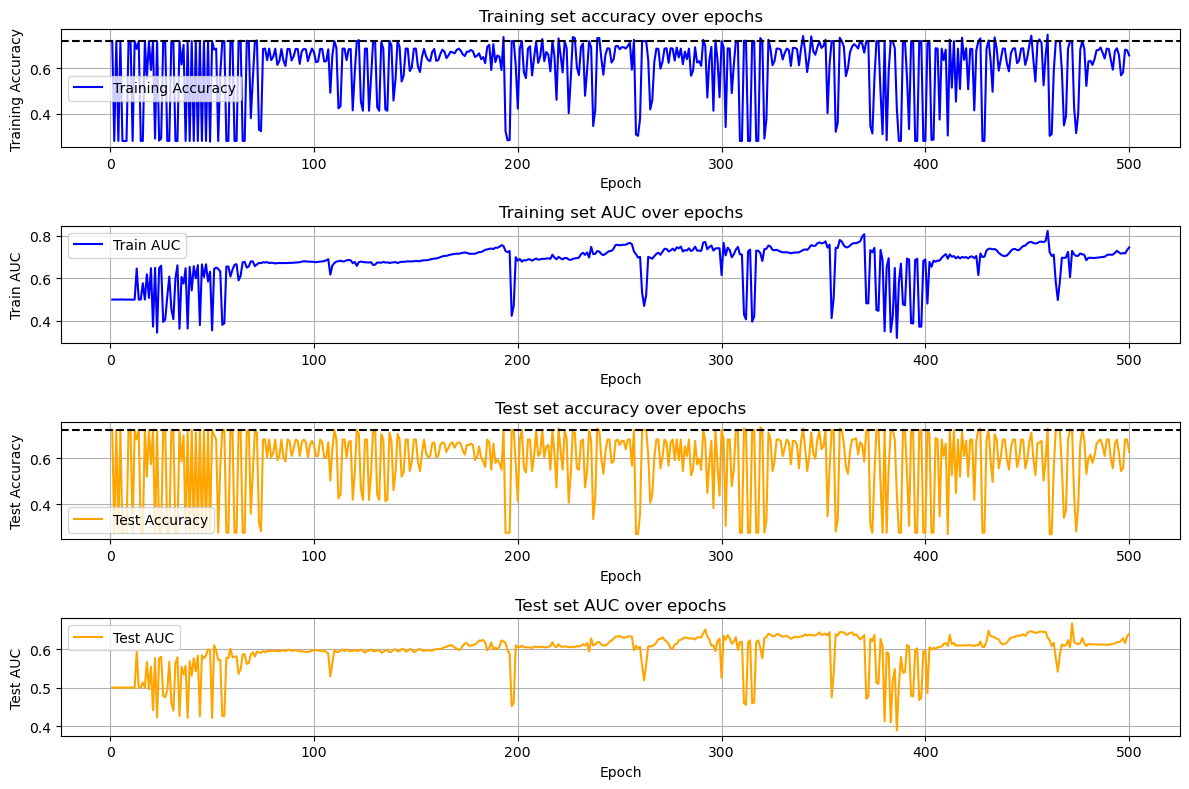

In [7]:
#evaluate the model
PAGEpy_plot.evaluate_model(old_model, current_data)

In [3]:
# select and optimized subset from the current set of features using the binary_pso function
best_solution, best_fitness = pso.binary_pso(current_genes, current_data, 200, 15,  C1 = 2, C2 = 1.5)

Current mixed precision policy: <Policy "mixed_float16">
Total time for generation 1: 2304.75 seconds
Generation 1: Best AUC = 0.663, Avg = 0.63722


Total time for generation 2: 2361.16 seconds
Generation 2: Best AUC = 0.663, Avg = 0.631


Total time for generation 3: 2394.34 seconds
Generation 3: Best AUC = 0.677, Avg = 0.657


Total time for generation 4: 2377.76 seconds
Generation 4: Best AUC = 0.679, Avg = 0.661


Total time for generation 5: 2329.18 seconds
Generation 5: Best AUC = 0.682, Avg = 0.663


Total time for generation 6: 2321.16 seconds
Generation 6: Best AUC = 0.683, Avg = 0.666


Total time for generation 7: 2339.34 seconds
Generation 7: Best AUC = 0.684, Avg = 0.668


Total time for generation 8: 2343.25 seconds
Generation 8: Best AUC = 0.688, Avg = 0.67


Total time for generation 9: 2337.54 seconds
Generation 9: Best AUC = 0.689, Avg = 0.67


Total time for generation 10: 2352.01 seconds
Generation 10: Best AUC = 0.694, Avg = 0.672


Total time for generation 11: 2

In [10]:
#check the result
print(f'pso solution has an average auc of: {best_fitness}')

pso solution has an average auc of: 0.696


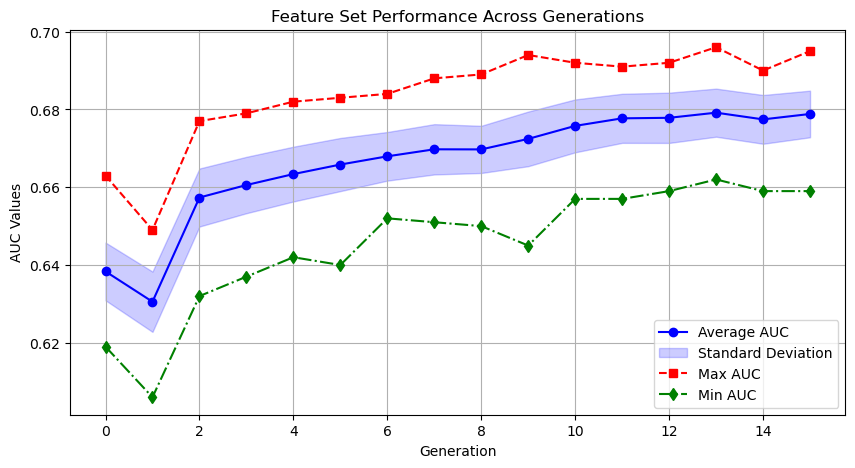

In [4]:
#monitor the progress made by the binray pso function
pso_df = pd.read_pickle("pso_df.pkl")
pso_dict = pd.read_pickle("pso_dict.pkl")

PAGEpy_plot.plot_pso_row_averages(pso_df)

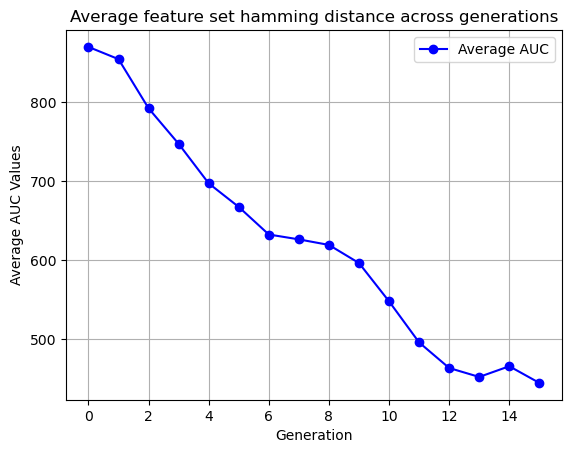

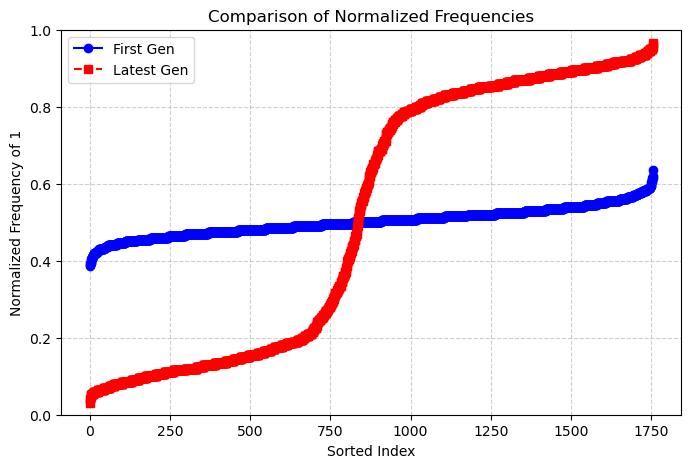

In [9]:
PAGEpy_plot.plot_hamming_distance(pso_dict)
PAGEpy_plot.plot_sorted_frequencies(pso_dict, pso_df)

pso solution has an average auc of: 0.696
Epoch 0, Avg Outcome Loss: 0.6832, Train AUC: 0.5000, Train Accuracy: 0.7214, Test AUC: 0.5000, Test Accuracy: 0.7246
Epoch 10, Avg Outcome Loss: 0.6836, Train AUC: 0.6533, Train Accuracy: 0.2786, Test AUC: 0.5861, Test Accuracy: 0.2754
Epoch 20, Avg Outcome Loss: 0.7462, Train AUC: 0.6505, Train Accuracy: 0.6883, Test AUC: 0.5953, Test Accuracy: 0.6826
Epoch 30, Avg Outcome Loss: 0.8439, Train AUC: 0.6672, Train Accuracy: 0.5783, Test AUC: 0.5934, Test Accuracy: 0.5629
Epoch 40, Avg Outcome Loss: 0.8393, Train AUC: 0.4098, Train Accuracy: 0.7214, Test AUC: 0.4885, Test Accuracy: 0.7246
Epoch 50, Avg Outcome Loss: 0.7005, Train AUC: 0.6674, Train Accuracy: 0.5783, Test AUC: 0.5952, Test Accuracy: 0.5629
Epoch 60, Avg Outcome Loss: 0.6535, Train AUC: 0.6625, Train Accuracy: 0.6867, Test AUC: 0.5897, Test Accuracy: 0.6826
Epoch 70, Avg Outcome Loss: 0.6368, Train AUC: 0.6726, Train Accuracy: 0.6687, Test AUC: 0.5938, Test Accuracy: 0.6527
Epoch 8

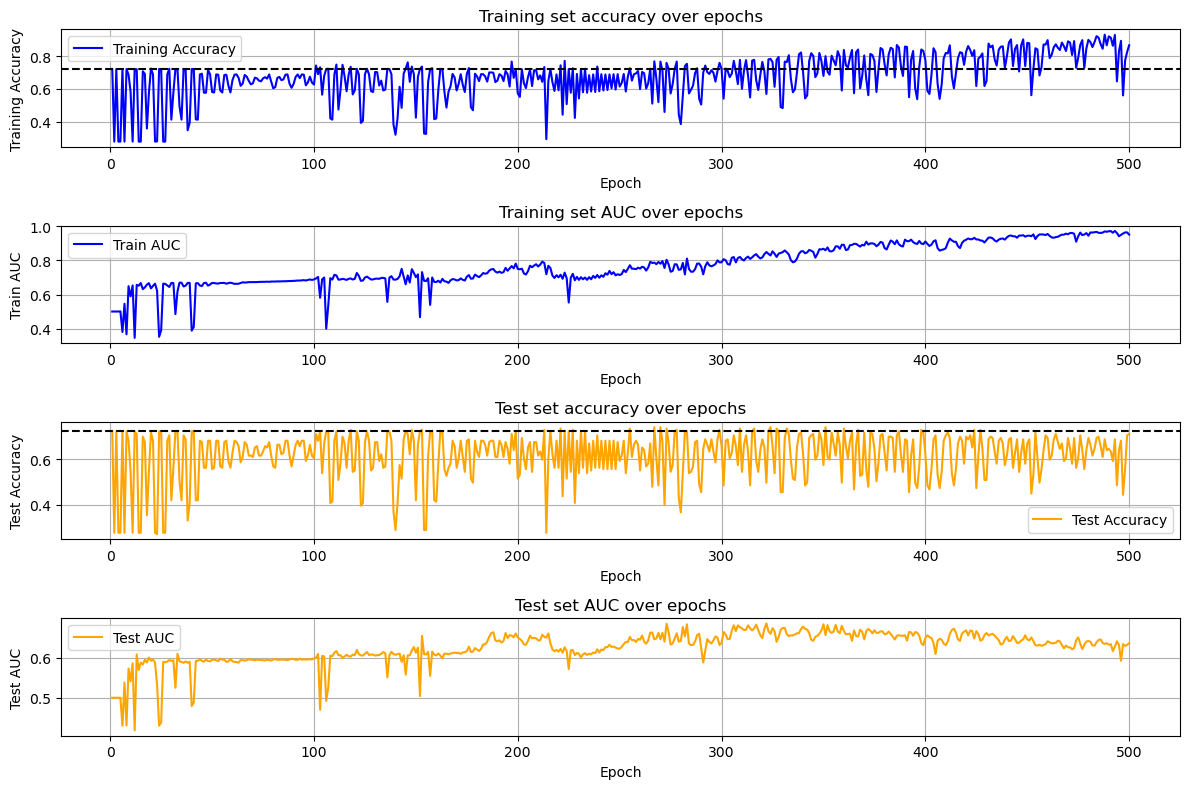

In [8]:
# the optimised solution is saved locally, however, the returned varible from the binary_pso function can also be passed to the model (see below)                                             
# pso_genes = [item for item, m in zip(current_genes, best_solution) if m == 1]

# othervise just load the locally stored result file

# Load the saved genes list
with open('pso_genes_result.pkl', 'rb') as f:
    pso_genes = pickle.load(f)
    
# now use this gene list to train a new model, which you can then evaluate
      
new_model = PredAnnModel(current_data,pso_genes,num_epochs=500)
PAGEpy_plot.evaluate_model(new_model, current_data)